### Env


In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, zscore
import pandas as pd
import os
import json
import glob
import time
import gc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip
import librosa
import librosa.display
from IPython.display import HTML
import zipfile
import ffmpeg
import random


### Data Prep

In [34]:
%%time
# List of file paths
file_paths = glob.glob('/home/tamires/projects/rpp-aevans-ab/tamires/data/fmri_derived/networks_data/sub-*.parquet')

# Read all Parquet files and concatenate them
df = pd.concat([pd.read_parquet(file) for file in file_paths]).reset_index(drop=True)
df = df.drop_duplicates()
df

CPU times: user 1.39 s, sys: 231 ms, total: 1.62 s
Wall time: 1.94 s


network  start   end      net_mean  \
0                   Autobiographical memory   5170  5180  2.073205e-08   
1               Cognitive attention control   5170  5180  0.000000e+00   
2          Extended multiple demand network   5170  5180  5.609849e-09   
3       Emotional scene and face processing   5170  5180 -1.589457e-08   
4                                   Empathy   5170  5180 -1.083721e-08   
...                                     ...    ...   ...           ...   
587583                               Reward   3360  3370  2.288818e-08   
587584                       Theory of mind   3360  3370  0.000000e+00   
587585                   Vigilant attention   3360  3370  0.000000e+00   
587586                       Working memory   3360  3370  8.292820e-09   
587587                      Semantic memory   3360  3370 -1.036603e-08   

        net_median  net_std  net_mean_abs  net_median_abs  net_std_abs  \
0        -0.057197      1.0      0.834074        0.778724     0.551652   
1         0.014002      1.0      0.853948        0.813794     0.520358   
2        -0.090933      1.0      0.793116        0.665117     0.609071   
3        -0.148895      1.0      0.821489        0.723178     0.570225   
4        -0.019501      1.0      0.806855        0.694684     0.590749   
...            ...      ...           ...             ...          ...   
587583   -0.050214      1.0      0.825229        0.709815     0.564799   
587584   -0.037312      1.0      0.819519        0.703020     0.573052   
587585   -0.073458      1.0      0.817270        0.726725     0.576255   
587586   -0.040339      1.0      0.806422        0.685802     0.591341   
587587    0.054991      1.0      0.827179        0.764326     0.561939   

        fc_mean_abs  fc_median_abs  fc_std_abs  sub            movie  
0          0.134495       0.082533    0.195118   10  500daysofsummer  
1          0.111728       0.062501    0.213091   10  500daysofsummer  
2          0.077614       0.020304    0.231017   10  500daysofsummer  
3          0.099848       0.054882    0.192017   10  500daysofsummer  
4          0.067476       0.021864    0.204114   10  500daysofsummer  
...             ...            ...         ...  ...              ...  
587583     0.098467       0.057274    0.188350    9  500daysofsummer  
587584     0.066667       0.000000    0.249444    9  500daysofsummer  
587585     0.166437       0.110014    0.224696    9  500daysofsummer  
587586     0.076663       0.035712    0.198111    9  500daysofsummer  
587587     0.152992       0.104761    0.196145    9  500daysofsummer  

[504000 rows x 14 columns]

In [3]:
#df.to_parquet('/home/tamires/projects/rpp-aevans-ab/tamires/data/fmri_derived/timestamps_networks_activation.parquet')

In [31]:
# 0-20, 50-86

In [32]:
#df_dummy = df[['sub','start']].drop_duplicates().groupby(['sub']).count()
#df_dummy.head(45)

In [33]:
#df_dummy.tail(45)

### Data Exploration

In [35]:
# Standardization
features = ['net_mean','net_median','net_std','net_mean_abs','net_median_abs','net_std_abs',	
             'fc_mean_abs','fc_median_abs','fc_std_abs']

new_columns = [f+'_standardized'for f in features]
standard_scaler = StandardScaler()
standardized_data = standard_scaler.fit_transform(df[features])
standardized_df = pd.DataFrame(standardized_data, columns=new_columns)
df = pd.concat([df, standardized_df], axis=1)
df

network   start     end      net_mean  \
0                   Autobiographical memory  5170.0  5180.0  2.073205e-08   
1               Cognitive attention control  5170.0  5180.0  0.000000e+00   
2          Extended multiple demand network  5170.0  5180.0  5.609849e-09   
3       Emotional scene and face processing  5170.0  5180.0 -1.589457e-08   
4                                   Empathy  5170.0  5180.0 -1.083721e-08   
...                                     ...     ...     ...           ...   
485943                                  NaN     NaN     NaN           NaN   
485944                                  NaN     NaN     NaN           NaN   
485945                                  NaN     NaN     NaN           NaN   
485946                                  NaN     NaN     NaN           NaN   
485947                                  NaN     NaN     NaN           NaN   

        net_median  net_std  net_mean_abs  net_median_abs  net_std_abs  \
0        -0.057197      1.0      0.834074        0.778724     0.551652   
1         0.014002      1.0      0.853948        0.813794     0.520358   
2        -0.090933      1.0      0.793116        0.665117     0.609071   
3        -0.148895      1.0      0.821489        0.723178     0.570225   
4        -0.019501      1.0      0.806855        0.694684     0.590749   
...            ...      ...           ...             ...          ...   
485943         NaN      NaN           NaN             NaN          NaN   
485944         NaN      NaN           NaN             NaN          NaN   
485945         NaN      NaN           NaN             NaN          NaN   
485946         NaN      NaN           NaN             NaN          NaN   
485947         NaN      NaN           NaN             NaN          NaN   

        fc_mean_abs  ...            movie  net_mean_standardized  \
0          0.134495  ...  500daysofsummer               1.703235   
1          0.111728  ...  500daysofsummer               0.001728   
2          0.077614  ...  500daysofsummer               0.462136   
3          0.099848  ...  500daysofsummer              -1.302760   
4          0.067476  ...  500daysofsummer              -0.887695   
...             ...  ...              ...                    ...   
485943          NaN  ...              NaN              -0.242863   
485944          NaN  ...              NaN               0.713268   
485945          NaN  ...              NaN              -0.277805   
485946          NaN  ...              NaN               0.653973   
485947          NaN  ...              NaN               0.357498   

        net_median_standardized net_std_standardized  \
0                     -0.936727             0.245179   
1                      0.199006             0.245179   
2                     -1.474886             0.245179   
3                     -2.399478             0.245179   
4                     -0.335418             0.245179   
...                         ...                  ...   
485943                -0.485381             0.245179   
485944                -0.298455             0.245179   
485945                 0.243590             0.245179   
485946                 0.063380             0.245179   
485947                 0.421216             0.245172   

        net_mean_abs_standardized  net_median_abs_standardized  \
0                        0.716027                     0.955990   
1                        1.707660                     1.650172   
2                       -1.327626                    -1.292793   
3                        0.088066                    -0.143515   
4                       -0.642079                    -0.707541   
...                           ...                          ...   
485943                  -0.399640                    -0.665508   
485944                   1.064627                     0.249883   
485945                   0.017177                    -0.657481   
485946                   0.018316                    -0.128467   
485947

In [4]:
df.describe()

start           end      net_mean    net_median       net_std  \
count  58800.000000  58800.000000  5.880000e+04  58800.000000  58800.000000   
mean    4415.000000   4425.000000 -6.129595e-11      0.000419      0.998051   
std      606.216064    606.216064  1.188113e-08      0.062321      0.008193   
min     3370.000000   3380.000000 -7.351240e-08     -0.279558      0.963624   
25%     3890.000000   3900.000000 -7.947286e-09     -0.039233      1.000000   
50%     4415.000000   4425.000000  0.000000e+00      0.000000      1.000000   
75%     4940.000000   4950.000000  7.947286e-09      0.039850      1.000000   
max     5460.000000   5470.000000  6.198883e-08      0.304058      1.000000   

       net_mean_abs  net_median_abs   net_std_abs   fc_mean_abs  \
count  58800.000000    58800.000000  58800.000000  58800.000000   
mean       0.819559        0.729888      0.568885      0.123988   
std        0.019867        0.050320      0.021726      0.039034   
min        0.709444        0.453922      0.454179      0.040000   
25%        0.811243        0.698371      0.554683      0.097564   
50%        0.821927        0.731108      0.569096      0.117222   
75%        0.831912        0.763422      0.583085      0.143348   
max        0.890911        0.938989      0.675597      0.480528   

       fc_median_abs  ...          sub  net_mean_standardized  \
count   58800.000000  ...  58800.00000           5.880000e+04   
mean        0.065864  ...     10.50000           9.244802e-09   
std         0.040762  ...      5.76633           1.000034e+00   
min         0.000000  ...      1.00000          -6.182119e+00   
25%         0.039871  ...      5.75000          -6.637359e-01   
50%         0.061185  ...     10.50000           5.159062e-03   
75%         0.085818  ...     15.25000           6.740540e-01   
max         0.564880  ...     20.00000           5.222540e+00   

       net_median_standardized  net_std_standardized  \
count             5.880000e+04          5.880000e+04   
mean              6.811959e-10          2.413380e-08   
std               1.000004e+00          9.995977e-01   
min              -4.492507e+00         -4.203188e+00   
25%              -6.362609e-01          2.379164e-01   
50%              -6.723021e-03          2.379164e-01   
75%               6.327050e-01          2.379164e-01   
max               4.872198e+00          2.379309e-01   

       net_mean_abs_standardized  net_median_abs_standardized  \
count               5.880000e+04                 5.880000e+04   
mean               -6.860616e-09                -1.427268e-09   
std                 1.000003e+00                 1.000005e+00   
min                -5.542507e+00                -5.484275e+00   
25%                -4.185390e-01                -6.263388e-01   
50%                 1.192298e-01                 2.424073e-02   
75%                 6.218218e-01                 6.664237e-01   
max                 3.591436e+00                 4.155487e+00   

       net_std_abs_standardized  fc_mean_abs_standardized  \
count              5.880000e+04              5.880000e+04   
mean               2.076026e-09             -1.038013e-08   
std                1.000004e+00              1.000011e+00   
min               -5.279715e+00             -2.151667e+00   
25%               -6.537179e-01             -6.769590e-01   
50%                9.716799e-03             -1.733498e-01   
75%                6.535995e-01              4.959776e-01   
max                4.911720e+00              9.134071e+00   

       fc_median_abs_standardized  fc_std_abs_standardized  
count                5.880000e+04             5.880000e+04  
mean                 3.114039e-09            -7.180941e-09  
std                  9.999943e-01             1.000005e+00  
min                 -1.615848e+00            -1.218246e+00  
25%                 -6.376824e-01            -9.084511e-01  
50%                 -1.147972e-01            -1.702420e-01  
75%                  4.895401e-01           

In [6]:
df.movie.unique()

array(['500daysofsummer', 'citizenfour', 'theusualsuspects',
       'pulpfiction', 'theshawshankredemption', 'theprestige',
       'backtothefuture', 'split', 'littlemisssunshine', '12yearsaslave'],
      dtype=object)

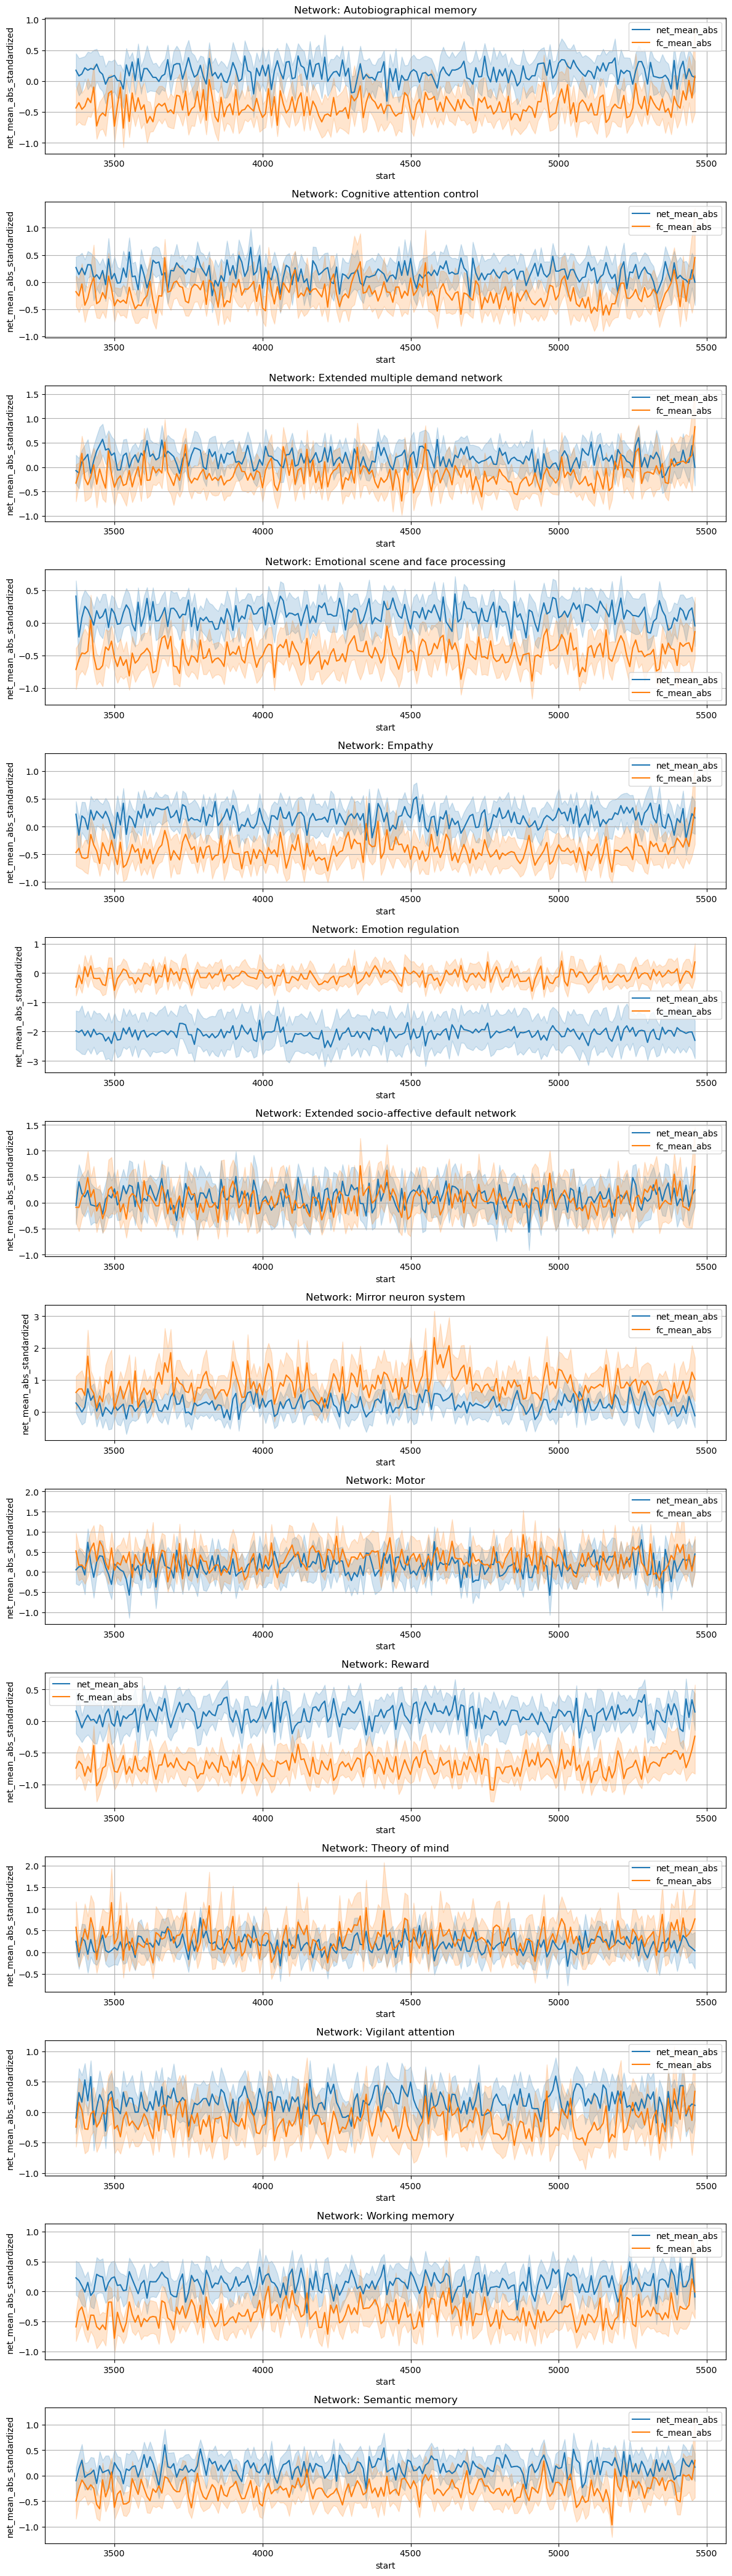

CPU times: user 2min 37s, sys: 619 ms, total: 2min 37s
Wall time: 6min 19s


In [8]:
%%time
df_one_movie = df[df.movie == '500daysofsummer']

# Create subplots dynamically based on the number of unique networks
unique_networks = df_one_movie.network.unique()
fig, axes = plt.subplots(len(unique_networks), 1, figsize=(12, 3 * len(unique_networks)))

# Ensure axes is always a list for consistency
if len(unique_networks) == 1:
    axes = [axes]

# Loop through each network and plot
for ax, network in zip(axes, unique_networks):
    sns.lineplot(
        x='start', 
        y='net_mean_abs_standardized', 
        data=df_one_movie[df_one_movie.network == network], 
        errorbar='ci', 
        ax=ax, 
        label='net_mean_abs'
    )
    sns.lineplot(
        x='start', 
        y='fc_mean_abs_standardized', 
        data= df_one_movie[df_one_movie.network == network], 
        errorbar='ci', 
        ax=ax, 
        label='fc_mean_abs'
    )
    ax.set_title(f'Network: {network}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

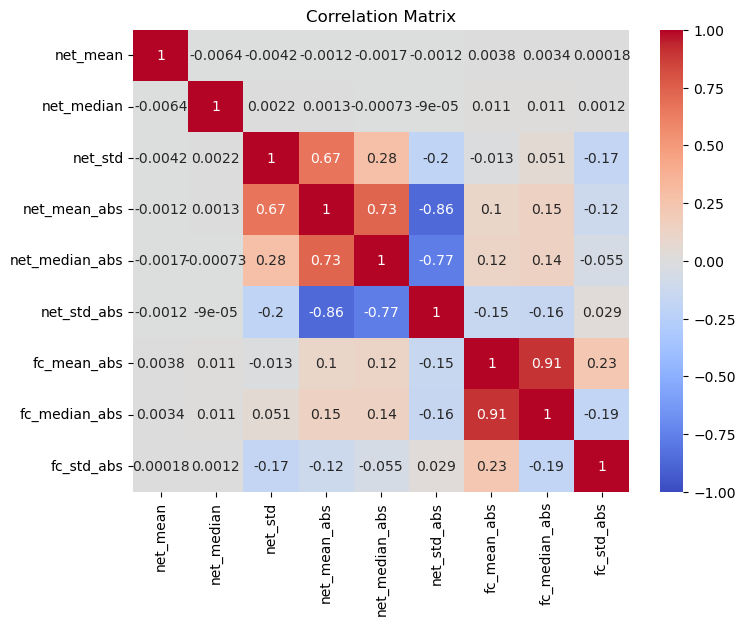

In [7]:
corr = df[features].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

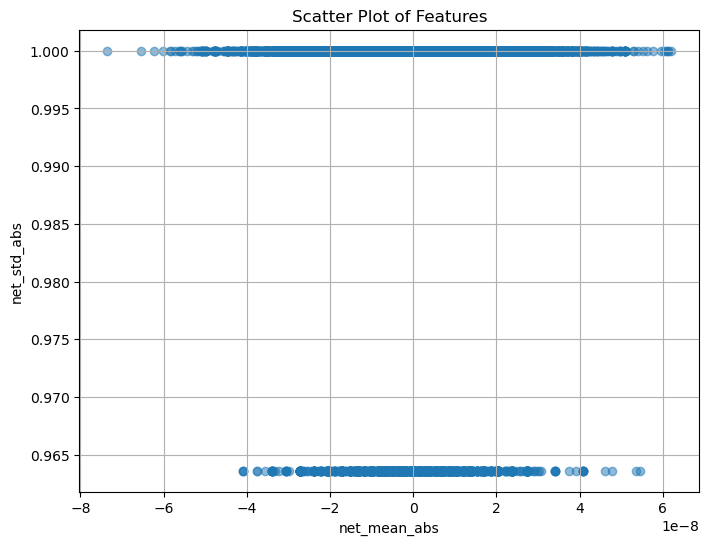

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(df['net_mean'], df['net_std'], alpha=0.5)
plt.title('Scatter Plot of Features')
plt.xlabel('net_mean_abs')
plt.ylabel('net_std_abs')
plt.grid(True)
plt.show()

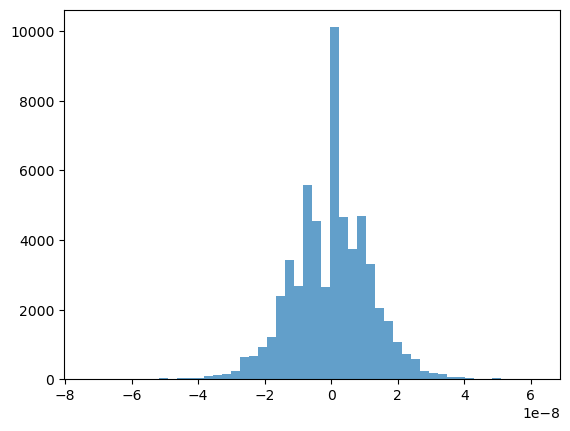

In [9]:
plt.hist(df['net_mean'], bins=50, alpha=0.7)
plt.show()

### Data Processessing

In [35]:
def get_best(df_general_mean, df_general_std, feature, threshold):

    ### mean
    best = df_general_mean.loc[df_general_mean[feature] > df_general_mean[feature].quantile(1-threshold)]
    print(f'Number of clips for mean criteria: {len(best)}')
    mean = best[['network', 'movie','start', 'end', feature]]
    mean = mean.rename(columns={feature: 'mean'}).set_index(['network', 'movie','start'])
    
    ### std
    best = df_general_std.loc[df_general_std[feature] < df_general_std[feature].quantile(threshold)]
    print(f'Number of clips for std criteria: {len(best)}')
    std = best[['network', 'movie','start', 'end', feature]]
    std = std.rename(columns={feature: 'std'}).set_index(['network', 'movie','start'])
    
    ### concatenacao e filtros
    result = pd.concat([mean, std], axis=1).reset_index()
    print(f'Number of clips after concatenation: {len(result)}')
    result = result.dropna()
    print(f'Number of clips after drop clips that doesnt have the two criteria (std and mean): {len(result)}')
    result = result.drop_duplicates(subset='start')
    print(f'Number of clips after drop duplicates networks: {len(result)}')
    print(f'Number of networks: {len(result.network.unique())}')
    print(f'Number of movies: {len(result.movie.unique())}')
    
    return result

In [36]:
df.columns

Index(['network', 'start', 'end', 'net_mean', 'net_median', 'net_std',
       'net_mean_abs', 'net_median_abs', 'net_std_abs', 'fc_mean_abs',
       'fc_median_abs', 'fc_std_abs', 'sub', 'movie'],
      dtype='object')

In [37]:
len(df)

504000

In [38]:
# Sumarize behavior of all individuals

df_general_mean = df.groupby(['network','movie', 'start', 'end']).mean().reset_index()
df_general_std = df.groupby(['network', 'movie','start', 'end']).std().reset_index()

In [164]:
# Get times of the best moments

df_best1 = get_best(df_general_mean, df_general_std, feature = 'net_median_abs', threshold = 0.05)
df_best1['method'] = 'net_median_abs_5'

Number of clips for mean criteria: 3024
Number of clips for std criteria: 2898
Number of clips after concatenation: 5784
Number of clips after drop clips that doesnt have the two criteria (std and mean): 138
Number of clips after drop duplicates networks: 134
Number of networks: 13
Number of movies: 8


In [165]:
# Get times of the best moments

df_best2 = get_best(df_general_mean, df_general_std, feature = 'fc_median_abs', threshold = 0.05)
df_best2['method'] = 'fc_median_abs_5'

Number of clips for mean criteria: 3024
Number of clips for std criteria: 2898
Number of clips after concatenation: 5917
Number of clips after drop clips that doesnt have the two criteria (std and mean): 5
Number of clips after drop duplicates networks: 5
Number of networks: 3
Number of movies: 3


In [166]:
# Get times of the best moments

df_best3 = get_best(df_general_mean, df_general_std, feature = 'net_median_abs', threshold = 0.1)
df_best3['method'] = 'net_median_abs_10'

Number of clips for mean criteria: 6048
Number of clips for std criteria: 5796
Number of clips after concatenation: 11208
Number of clips after drop clips that doesnt have the two criteria (std and mean): 636
Number of clips after drop duplicates networks: 556
Number of networks: 14
Number of movies: 8


In [167]:
# Get times of the best moments

df_best4 = get_best(df_general_mean, df_general_std, feature = 'fc_median_abs', threshold = 0.1)
df_best4['method'] = 'fc_median_abs_10'

Number of clips for mean criteria: 6048
Number of clips for std criteria: 5796
Number of clips after concatenation: 11776
Number of clips after drop clips that doesnt have the two criteria (std and mean): 68
Number of clips after drop duplicates networks: 68
Number of networks: 12
Number of movies: 8


In [168]:
df_double_best = pd.concat([df_best3, df_best4]).reset_index(drop=True)
df_double_best = df_double_best[df_double_best.duplicated(subset=['network', 'movie', 'start'])]
print(f'Number of clips that are the best in net and fc method: {len(df_double_best)}')
print(f'Number of networks: {len(df_double_best.network.unique())}')
print(f'Number of movies: {len(df_double_best.movie.unique())}')
df_double_best['method']= ['double_metric_10']*len(df_double_best)

Number of clips that are the best in net and fc method: 2
Number of networks: 2
Number of movies: 1


In [169]:
df_best = pd.concat([df_best1, df_best2, df_double_best]).reset_index(drop=True)
df_best["network"] = [ network.replace(" ", "_") for network in df_best["network"]]
df_best

network                   movie  start     end  \
0        Autobiographical_memory             pulpfiction   4352  4362.0   
1        Autobiographical_memory             pulpfiction   7092  7102.0   
2        Autobiographical_memory             pulpfiction   8192  8202.0   
3        Autobiographical_memory             pulpfiction   8362  8372.0   
4        Autobiographical_memory        theusualsuspects   1482  1492.0   
..                           ...                     ...    ...     ...   
136              Semantic_memory                   split   4559  4569.0   
137              Semantic_memory  theshawshankredemption   8171  8181.0   
138               Theory_of_mind             pulpfiction   3772  3782.0   
139  Cognitive_attention_control             pulpfiction   3762  3772.0   
140               Working_memory             pulpfiction   8842  8852.0   

         mean     end       std            method  
0    0.804382  4362.0  0.016939  net_median_abs_5  
1    0.769936  7102.0  0.021765  net_median_abs_5  
2    0.780078  8202.0  0.017381  net_median_abs_5  
3    0.773516  8372.0  0.022802  net_median_abs_5  
4    0.787692  1492.0  0.022621  net_median_abs_5  
..        ...     ...       ...               ...  
136  0.111659  4569.0  0.012429   fc_median_abs_5  
137  0.113264  8181.0  0.011870   fc_median_abs_5  
138  0.128537  3782.0  0.013547   fc_median_abs_5  
139  0.115604  3772.0  0.017340  double_metric_10  
140  0.099117  8852.0  0.013537  double_metric_10  

[141 rows x 8 columns]

### Movie Prep

##### Syncronization

In [170]:
# Load movies
movies = {}
movies['500daysofsummer'] = VideoFileClip("/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_raw/500daysofsummer10429186727001467.mp4")
movies['citizenfour'] = VideoFileClip("/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_raw/citizenfour1000973324.mp4")
movies['pulpfiction'] = VideoFileClip("/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_raw/pulfiction1042741561.mp4")
movies['theshawshankredemption'] = VideoFileClip("/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_raw/theshawshankredemption1041539426.mp4")
movies['theprestige'] = VideoFileClip("/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_raw/theprestige1042694398.mp4")
movies['backtothefuture'] = VideoFileClip("/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_raw/backtothefuture10426939500506143.mp4")
movies['littlemisssunshine'] = VideoFileClip("/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_raw/littlemisssunshine1043036029.mp4")
movies['12yearsaslave'] = VideoFileClip("/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_raw/12yearsaslave1042662768.mp4")

# Load and Enrich sync table
sync_movies = pd.read_csv("/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_raw/sync_movies.csv")
sync_movies = sync_movies.replace(',', '.', regex=True)
sync_movies["init_diff"] = sync_movies["start_time_first_word_lab"].astype(float) - sync_movies["start_time_first_word_mine"].astype(float)
sync_movies["final_diff"] = sync_movies["end_time_last_word_lab"].astype(float) - sync_movies["end_time_last_word_mine"].astype(float)
len_mine = pd.DataFrame([ [name, movies[name].duration] for name in movies]).rename(columns={0:"movie", 1:"len_mine"})
sync_movies = pd.merge(len_mine, sync_movies,  on='movie', how='inner')
sync_movies['word_diff'] = (sync_movies['init_diff']- sync_movies['final_diff'])
sync_movies['len_diff'] = sync_movies['len_mine'] - sync_movies['len_lab']
sync_movies

movie  len_mine  len_lab start_time_first_word_lab  \
0         500daysofsummer   5469.86     5470                  61.97700   
1             citizenfour   6802.81     6804                  45.49000   
2             pulpfiction   8916.45     8882                  27.00000   
3  theshawshankredemption   8211.47     8181                   2.00000   
4             theprestige   7504.97     7515                  66.74000   
5         backtothefuture   6677.24     6674                  86.54000   
6      littlemisssunshine   5900.34     5900                  43.00000   
7           12yearsaslave   7720.75     7715                  61.14000   

  end_time_last_word_lab start_time_first_word_mine end_time_last_word_mine  \
0             5373.93143                   63.00000              5374.48333   
1             6579.11400                   43.05000              6579.40000   
2             8582.10800                   27.35000              8582.21667   
3             7910.23000                   22.35000              7933.30000   
4             7202.19600                   55.18333              7190.43333   
5             6422.02000                   87.43333              6423.15000   
6             5866.88000                   42.05000              5865.13333   
7             7687.75100                   67.25000              7694.21667   

   init_diff  final_diff  word_diff  len_diff  
0   -1.02300    -0.55190   -0.47110     -0.14  
1    2.44000    -0.28600    2.72600     -1.19  
2   -0.35000    -0.10867   -0.24133     34.45  
3  -20.35000   -23.07000    2.72000     30.47  
4   11.55667    11.76267   -0.20600    -10.03  
5   -0.89333    -1.13000    0.23667      3.24  
6    0.95000     1.74667   -0.79667      0.34  
7   -6.11000    -6.46567    0.35567      5.75

In [171]:
df_best_enriched = pd.merge(df_best, sync_movies[["movie","init_diff"]],  on='movie', how='inner')
#df_best_enriched.to_csv('/home/tamires/projects/rpp-aevans-ab/tamires/data/fmri_derived/timestamps_best.csv')
df_best_enriched

network                   movie  start     end  \
0        Autobiographical_memory             pulpfiction   4352  4362.0   
1        Autobiographical_memory             pulpfiction   7092  7102.0   
2        Autobiographical_memory             pulpfiction   8192  8202.0   
3        Autobiographical_memory             pulpfiction   8362  8372.0   
4    Cognitive_attention_control           12yearsaslave   6585  6595.0   
..                           ...                     ...    ...     ...   
103              Semantic_memory             pulpfiction   8762  8772.0   
104              Semantic_memory  theshawshankredemption   8171  8181.0   
105               Theory_of_mind             pulpfiction   3772  3782.0   
106  Cognitive_attention_control             pulpfiction   3762  3772.0   
107               Working_memory             pulpfiction   8842  8852.0   

         mean     end       std            method  init_diff  
0    0.804382  4362.0  0.016939  net_median_abs_5      -0.35  
1    0.769936  7102.0  0.021765  net_median_abs_5      -0.35  
2    0.780078  8202.0  0.017381  net_median_abs_5      -0.35  
3    0.773516  8372.0  0.022802  net_median_abs_5      -0.35  
4    0.770607  6595.0  0.020846  net_median_abs_5      -6.11  
..        ...     ...       ...               ...        ...  
103  0.111400  8772.0  0.013783   fc_median_abs_5      -0.35  
104  0.113264  8181.0  0.011870   fc_median_abs_5     -20.35  
105  0.128537  3782.0  0.013547   fc_median_abs_5      -0.35  
106  0.115604  3772.0  0.017340  double_metric_10      -0.35  
107  0.099117  8852.0  0.013537  double_metric_10      -0.35  

[108 rows x 9 columns]

##### Cutting

In [172]:
def cut_clips(movie, start_time, end_time, init_diff, network, method):
    # cut
    movie_file = movies[movie]
    real_start_time = start_time - init_diff
    real_end_time = end_time - init_diff
    clip = movie_file.subclip(real_start_time, real_end_time)

    # save
    output_dir = "/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2"
    clip_path = os.path.join(output_dir, f"{network}_{movie}_{method}_{start_time}_{end_time}_clip.mp4")
    clip.write_videofile(clip_path) 

for row in df_best_enriched.itertuples(index=False):
    try:
        cut_clips(row.movie, row.start, row.end, row.init_diff, row.network, row.method)
    except Exception as e:
        print(f"An error occurred: {e}")

Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_4352_4362.0_clip.mp4.
MoviePy - Writing audio in Autobiographical_memory_pulpfiction_net_median_abs_5_4352_4362.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_4352_4362.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_4352_4362.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_7092_7102.0_clip.mp4.
MoviePy - Writing audio in Autobiographical_memory_pulpfiction_net_median_abs_5_7092_7102.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_7092_7102.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_7092_7102.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_8192_8202.0_clip.mp4.
MoviePy - Writing audio in Autobiographical_memory_pulpfiction_net_median_abs_5_8192_8202.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_8192_8202.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_8192_8202.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_8362_8372.0_clip.mp4.
MoviePy - Writing audio in Autobiographical_memory_pulpfiction_net_median_abs_5_8362_8372.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_8362_8372.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_8362_8372.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_12yearsaslave_net_median_abs_5_6585_6595.0_clip.mp4.
MoviePy - Writing audio in Cognitive_attention_control_12yearsaslave_net_median_abs_5_6585_6595.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_12yearsaslave_net_median_abs_5_6585_6595.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_12yearsaslave_net_median_abs_5_6585_6595.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_backtothefuture_net_median_abs_5_4014_4024.0_clip.mp4.
MoviePy - Writing audio in Cognitive_attention_control_backtothefuture_net_median_abs_5_4014_4024.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_backtothefuture_net_median_abs_5_4014_4024.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_backtothefuture_net_median_abs_5_4014_4024.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_littlemisssunshine_net_median_abs_5_4440_4450.0_clip.mp4.
MoviePy - Writing audio in Cognitive_attention_control_littlemisssunshine_net_median_abs_5_4440_4450.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_littlemisssunshine_net_median_abs_5_4440_4450.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_littlemisssunshine_net_median_abs_5_4440_4450.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_pulpfiction_net_median_abs_5_4732_4742.0_clip.mp4.
MoviePy - Writing audio in Cognitive_attention_control_pulpfiction_net_median_abs_5_4732_4742.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_pulpfiction_net_median_abs_5_4732_4742.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_pulpfiction_net_median_abs_5_4732_4742.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_pulpfiction_net_median_abs_5_8122_8132.0_clip.mp4.
MoviePy - Writing audio in Cognitive_attention_control_pulpfiction_net_median_abs_5_8122_8132.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_pulpfiction_net_median_abs_5_8122_8132.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_pulpfiction_net_median_abs_5_8122_8132.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_theprestige_net_median_abs_5_4355_4365.0_clip.mp4.
MoviePy - Writing audio in Cognitive_attention_control_theprestige_net_median_abs_5_4355_4365.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_theprestige_net_median_abs_5_4355_4365.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_theprestige_net_median_abs_5_4355_4365.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_12yearsaslave_net_median_abs_5_4855_4865.0_clip.mp4.
MoviePy - Writing audio in Emotional_scene_and_face_processing_12yearsaslave_net_median_abs_5_4855_4865.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_12yearsaslave_net_median_abs_5_4855_4865.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_12yearsaslave_net_median_abs_5_4855_4865.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_3742_3752.0_clip.mp4.
MoviePy - Writing audio in Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_3742_3752.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_3742_3752.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_3742_3752.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_4992_5002.0_clip.mp4.
MoviePy - Writing audio in Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_4992_5002.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_4992_5002.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_4992_5002.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_5042_5052.0_clip.mp4.
MoviePy - Writing audio in Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_5042_5052.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_5042_5052.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_5042_5052.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_5922_5932.0_clip.mp4.
MoviePy - Writing audio in Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_5922_5932.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_5922_5932.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_5922_5932.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_theprestige_net_median_abs_5_4115_4125.0_clip.mp4.
MoviePy - Writing audio in Emotional_scene_and_face_processing_theprestige_net_median_abs_5_4115_4125.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_theprestige_net_median_abs_5_4115_4125.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_theprestige_net_median_abs_5_4115_4125.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_theshawshankredemption_net_median_abs_5_5171_5181.0_clip.mp4.
MoviePy - Writing audio in Emotional_scene_and_face_processing_theshawshankredemption_net_median_abs_5_5171_5181.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_theshawshankredemption_net_median_abs_5_5171_5181.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Emotional_scene_and_face_processing_theshawshankredemption_net_median_abs_5_5171_5181.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Empathy_12yearsaslave_net_median_abs_5_6115_6125.0_clip.mp4.
MoviePy - Writing audio in Empathy_12yearsaslave_net_median_abs_5_6115_6125.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Empathy_12yearsaslave_net_median_abs_5_6115_6125.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Empathy_12yearsaslave_net_median_abs_5_6115_6125.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Empathy_pulpfiction_net_median_abs_5_6332_6342.0_clip.mp4.
MoviePy - Writing audio in Empathy_pulpfiction_net_median_abs_5_6332_6342.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Empathy_pulpfiction_net_median_abs_5_6332_6342.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Empathy_pulpfiction_net_median_abs_5_6332_6342.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Empathy_pulpfiction_net_median_abs_5_6572_6582.0_clip.mp4.
MoviePy - Writing audio in Empathy_pulpfiction_net_median_abs_5_6572_6582.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Empathy_pulpfiction_net_median_abs_5_6572_6582.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Empathy_pulpfiction_net_median_abs_5_6572_6582.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Empathy_pulpfiction_net_median_abs_5_7042_7052.0_clip.mp4.
MoviePy - Writing audio in Empathy_pulpfiction_net_median_abs_5_7042_7052.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Empathy_pulpfiction_net_median_abs_5_7042_7052.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Empathy_pulpfiction_net_median_abs_5_7042_7052.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_littlemisssunshine_net_median_abs_5_4760_4770.0_clip.mp4.
MoviePy - Writing audio in Extended_multiple_demand_network_littlemisssunshine_net_median_abs_5_4760_4770.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_littlemisssunshine_net_median_abs_5_4760_4770.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_littlemisssunshine_net_median_abs_5_4760_4770.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_4702_4712.0_clip.mp4.
MoviePy - Writing audio in Extended_multiple_demand_network_pulpfiction_net_median_abs_5_4702_4712.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_4702_4712.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_4702_4712.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_4952_4962.0_clip.mp4.
MoviePy - Writing audio in Extended_multiple_demand_network_pulpfiction_net_median_abs_5_4952_4962.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_4952_4962.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_4952_4962.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_6942_6952.0_clip.mp4.
MoviePy - Writing audio in Extended_multiple_demand_network_pulpfiction_net_median_abs_5_6942_6952.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_6942_6952.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_6942_6952.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_7962_7972.0_clip.mp4.
MoviePy - Writing audio in Extended_multiple_demand_network_pulpfiction_net_median_abs_5_7962_7972.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_7962_7972.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_7962_7972.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_theprestige_net_median_abs_5_4795_4805.0_clip.mp4.
MoviePy - Writing audio in Extended_multiple_demand_network_theprestige_net_median_abs_5_4795_4805.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_theprestige_net_median_abs_5_4795_4805.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_theprestige_net_median_abs_5_4795_4805.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_theprestige_net_median_abs_5_6185_6195.0_clip.mp4.
MoviePy - Writing audio in Extended_multiple_demand_network_theprestige_net_median_abs_5_6185_6195.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_theprestige_net_median_abs_5_6185_6195.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_theprestige_net_median_abs_5_6185_6195.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_theshawshankredemption_net_median_abs_5_7321_7331.0_clip.mp4.
MoviePy - Writing audio in Extended_multiple_demand_network_theshawshankredemption_net_median_abs_5_7321_7331.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_theshawshankredemption_net_median_abs_5_7321_7331.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_theshawshankredemption_net_median_abs_5_7321_7331.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_theshawshankredemption_net_median_abs_5_7581_7591.0_clip.mp4.
MoviePy - Writing audio in Extended_multiple_demand_network_theshawshankredemption_net_median_abs_5_7581_7591.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_theshawshankredemption_net_median_abs_5_7581_7591.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_multiple_demand_network_theshawshankredemption_net_median_abs_5_7581_7591.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_12yearsaslave_net_median_abs_5_5775_5785.0_clip.mp4.
MoviePy - Writing audio in Extended_socio-affective_default_network_12yearsaslave_net_median_abs_5_5775_5785.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_12yearsaslave_net_median_abs_5_5775_5785.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_12yearsaslave_net_median_abs_5_5775_5785.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_12yearsaslave_net_median_abs_5_6925_6935.0_clip.mp4.
MoviePy - Writing audio in Extended_socio-affective_default_network_12yearsaslave_net_median_abs_5_6925_6935.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_12yearsaslave_net_median_abs_5_6925_6935.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_12yearsaslave_net_median_abs_5_6925_6935.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_backtothefuture_net_median_abs_5_6394_6404.0_clip.mp4.
MoviePy - Writing audio in Extended_socio-affective_default_network_backtothefuture_net_median_abs_5_6394_6404.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_backtothefuture_net_median_abs_5_6394_6404.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_backtothefuture_net_median_abs_5_6394_6404.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_littlemisssunshine_net_median_abs_5_5080_5090.0_clip.mp4.
MoviePy - Writing audio in Extended_socio-affective_default_network_littlemisssunshine_net_median_abs_5_5080_5090.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_littlemisssunshine_net_median_abs_5_5080_5090.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_littlemisssunshine_net_median_abs_5_5080_5090.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_pulpfiction_net_median_abs_5_3692_3702.0_clip.mp4.
MoviePy - Writing audio in Extended_socio-affective_default_network_pulpfiction_net_median_abs_5_3692_3702.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_pulpfiction_net_median_abs_5_3692_3702.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_pulpfiction_net_median_abs_5_3692_3702.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_theprestige_net_median_abs_5_6005_6015.0_clip.mp4.
MoviePy - Writing audio in Extended_socio-affective_default_network_theprestige_net_median_abs_5_6005_6015.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_theprestige_net_median_abs_5_6005_6015.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_theprestige_net_median_abs_5_6005_6015.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_backtothefuture_net_median_abs_5_6044_6054.0_clip.mp4.
MoviePy - Writing audio in Mirror_neuron_system_backtothefuture_net_median_abs_5_6044_6054.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_backtothefuture_net_median_abs_5_6044_6054.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_backtothefuture_net_median_abs_5_6044_6054.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_3792_3802.0_clip.mp4.
MoviePy - Writing audio in Mirror_neuron_system_pulpfiction_net_median_abs_5_3792_3802.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_3792_3802.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_3792_3802.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_5592_5602.0_clip.mp4.
MoviePy - Writing audio in Mirror_neuron_system_pulpfiction_net_median_abs_5_5592_5602.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_5592_5602.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_5592_5602.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_6892_6902.0_clip.mp4.
MoviePy - Writing audio in Mirror_neuron_system_pulpfiction_net_median_abs_5_6892_6902.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_6892_6902.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_6892_6902.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_8182_8192.0_clip.mp4.
MoviePy - Writing audio in Mirror_neuron_system_pulpfiction_net_median_abs_5_8182_8192.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_8182_8192.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_8182_8192.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_theprestige_net_median_abs_5_6425_6435.0_clip.mp4.
MoviePy - Writing audio in Mirror_neuron_system_theprestige_net_median_abs_5_6425_6435.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_theprestige_net_median_abs_5_6425_6435.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_theprestige_net_median_abs_5_6425_6435.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_theshawshankredemption_net_median_abs_5_4721_4731.0_clip.mp4.
MoviePy - Writing audio in Mirror_neuron_system_theshawshankredemption_net_median_abs_5_4721_4731.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_theshawshankredemption_net_median_abs_5_4721_4731.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_theshawshankredemption_net_median_abs_5_4721_4731.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_theshawshankredemption_net_median_abs_5_7301_7311.0_clip.mp4.
MoviePy - Writing audio in Mirror_neuron_system_theshawshankredemption_net_median_abs_5_7301_7311.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_theshawshankredemption_net_median_abs_5_7301_7311.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_theshawshankredemption_net_median_abs_5_7301_7311.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_theshawshankredemption_net_median_abs_5_7521_7531.0_clip.mp4.
MoviePy - Writing audio in Mirror_neuron_system_theshawshankredemption_net_median_abs_5_7521_7531.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_theshawshankredemption_net_median_abs_5_7521_7531.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Mirror_neuron_system_theshawshankredemption_net_median_abs_5_7521_7531.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Motor_12yearsaslave_net_median_abs_5_4785_4795.0_clip.mp4.
MoviePy - Writing audio in Motor_12yearsaslave_net_median_abs_5_4785_4795.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Motor_12yearsaslave_net_median_abs_5_4785_4795.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Motor_12yearsaslave_net_median_abs_5_4785_4795.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Motor_littlemisssunshine_net_median_abs_5_3260_3270.0_clip.mp4.
MoviePy - Writing audio in Motor_littlemisssunshine_net_median_abs_5_3260_3270.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Motor_littlemisssunshine_net_median_abs_5_3260_3270.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Motor_littlemisssunshine_net_median_abs_5_3260_3270.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Motor_pulpfiction_net_median_abs_5_7142_7152.0_clip.mp4.
MoviePy - Writing audio in Motor_pulpfiction_net_median_abs_5_7142_7152.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Motor_pulpfiction_net_median_abs_5_7142_7152.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Motor_pulpfiction_net_median_abs_5_7142_7152.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_backtothefuture_net_median_abs_5_5164_5174.0_clip.mp4.
MoviePy - Writing audio in Reward_backtothefuture_net_median_abs_5_5164_5174.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_backtothefuture_net_median_abs_5_5164_5174.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_backtothefuture_net_median_abs_5_5164_5174.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_littlemisssunshine_net_median_abs_5_2600_2610.0_clip.mp4.
MoviePy - Writing audio in Reward_littlemisssunshine_net_median_abs_5_2600_2610.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_littlemisssunshine_net_median_abs_5_2600_2610.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_littlemisssunshine_net_median_abs_5_2600_2610.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_pulpfiction_net_median_abs_5_3882_3892.0_clip.mp4.
MoviePy - Writing audio in Reward_pulpfiction_net_median_abs_5_3882_3892.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_pulpfiction_net_median_abs_5_3882_3892.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_pulpfiction_net_median_abs_5_3882_3892.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_pulpfiction_net_median_abs_5_7492_7502.0_clip.mp4.
MoviePy - Writing audio in Reward_pulpfiction_net_median_abs_5_7492_7502.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_pulpfiction_net_median_abs_5_7492_7502.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_pulpfiction_net_median_abs_5_7492_7502.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_theprestige_net_median_abs_5_4405_4415.0_clip.mp4.
MoviePy - Writing audio in Reward_theprestige_net_median_abs_5_4405_4415.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_theprestige_net_median_abs_5_4405_4415.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Reward_theprestige_net_median_abs_5_4405_4415.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_3164_3174.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_backtothefuture_net_median_abs_5_3164_3174.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_3164_3174.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_3164_3174.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_3284_3294.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_backtothefuture_net_median_abs_5_3284_3294.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_3284_3294.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_3284_3294.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_3634_3644.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_backtothefuture_net_median_abs_5_3634_3644.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_3634_3644.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_3634_3644.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_4124_4134.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_backtothefuture_net_median_abs_5_4124_4134.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_4124_4134.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_4124_4134.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_4194_4204.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_backtothefuture_net_median_abs_5_4194_4204.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_4194_4204.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_4194_4204.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_4784_4794.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_backtothefuture_net_median_abs_5_4784_4794.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_4784_4794.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_4784_4794.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_5284_5294.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_backtothefuture_net_median_abs_5_5284_5294.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_5284_5294.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_backtothefuture_net_median_abs_5_5284_5294.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_littlemisssunshine_net_median_abs_5_4320_4330.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_littlemisssunshine_net_median_abs_5_4320_4330.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_littlemisssunshine_net_median_abs_5_4320_4330.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_littlemisssunshine_net_median_abs_5_4320_4330.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_pulpfiction_net_median_abs_5_6522_6532.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_pulpfiction_net_median_abs_5_6522_6532.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_pulpfiction_net_median_abs_5_6522_6532.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_pulpfiction_net_median_abs_5_6522_6532.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_pulpfiction_net_median_abs_5_6842_6852.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_pulpfiction_net_median_abs_5_6842_6852.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_pulpfiction_net_median_abs_5_6842_6852.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_pulpfiction_net_median_abs_5_6842_6852.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_pulpfiction_net_median_abs_5_6982_6992.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_pulpfiction_net_median_abs_5_6982_6992.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_pulpfiction_net_median_abs_5_6982_6992.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_pulpfiction_net_median_abs_5_6982_6992.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theprestige_net_median_abs_5_4145_4155.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_theprestige_net_median_abs_5_4145_4155.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theprestige_net_median_abs_5_4145_4155.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theprestige_net_median_abs_5_4145_4155.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theprestige_net_median_abs_5_4815_4825.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_theprestige_net_median_abs_5_4815_4825.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theprestige_net_median_abs_5_4815_4825.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theprestige_net_median_abs_5_4815_4825.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theprestige_net_median_abs_5_6525_6535.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_theprestige_net_median_abs_5_6525_6535.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theprestige_net_median_abs_5_6525_6535.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theprestige_net_median_abs_5_6525_6535.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theprestige_net_median_abs_5_7315_7325.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_theprestige_net_median_abs_5_7315_7325.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theprestige_net_median_abs_5_7315_7325.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theprestige_net_median_abs_5_7315_7325.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_12yearsaslave_net_median_abs_5_5895_5905.0_clip.mp4.
MoviePy - Writing audio in Theory_of_mind_12yearsaslave_net_median_abs_5_5895_5905.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_12yearsaslave_net_median_abs_5_5895_5905.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_12yearsaslave_net_median_abs_5_5895_5905.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_backtothefuture_net_median_abs_5_6364_6374.0_clip.mp4.
MoviePy - Writing audio in Theory_of_mind_backtothefuture_net_median_abs_5_6364_6374.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_backtothefuture_net_median_abs_5_6364_6374.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_backtothefuture_net_median_abs_5_6364_6374.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_littlemisssunshine_net_median_abs_5_3680_3690.0_clip.mp4.
MoviePy - Writing audio in Theory_of_mind_littlemisssunshine_net_median_abs_5_3680_3690.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_littlemisssunshine_net_median_abs_5_3680_3690.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_littlemisssunshine_net_median_abs_5_3680_3690.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_net_median_abs_5_4062_4072.0_clip.mp4.
MoviePy - Writing audio in Theory_of_mind_pulpfiction_net_median_abs_5_4062_4072.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_net_median_abs_5_4062_4072.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_net_median_abs_5_4062_4072.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_net_median_abs_5_4072_4082.0_clip.mp4.
MoviePy - Writing audio in Theory_of_mind_pulpfiction_net_median_abs_5_4072_4082.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_net_median_abs_5_4072_4082.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_net_median_abs_5_4072_4082.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_net_median_abs_5_6392_6402.0_clip.mp4.
MoviePy - Writing audio in Theory_of_mind_pulpfiction_net_median_abs_5_6392_6402.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_net_median_abs_5_6392_6402.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_net_median_abs_5_6392_6402.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_net_median_abs_5_8152_8162.0_clip.mp4.
MoviePy - Writing audio in Theory_of_mind_pulpfiction_net_median_abs_5_8152_8162.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_net_median_abs_5_8152_8162.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_net_median_abs_5_8152_8162.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_theshawshankredemption_net_median_abs_5_5961_5971.0_clip.mp4.
MoviePy - Writing audio in Theory_of_mind_theshawshankredemption_net_median_abs_5_5961_5971.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_theshawshankredemption_net_median_abs_5_5961_5971.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_theshawshankredemption_net_median_abs_5_5961_5971.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_12yearsaslave_net_median_abs_5_5095_5105.0_clip.mp4.
MoviePy - Writing audio in Vigilant_attention_12yearsaslave_net_median_abs_5_5095_5105.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_12yearsaslave_net_median_abs_5_5095_5105.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_12yearsaslave_net_median_abs_5_5095_5105.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_12yearsaslave_net_median_abs_5_6985_6995.0_clip.mp4.
MoviePy - Writing audio in Vigilant_attention_12yearsaslave_net_median_abs_5_6985_6995.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_12yearsaslave_net_median_abs_5_6985_6995.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_12yearsaslave_net_median_abs_5_6985_6995.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_littlemisssunshine_net_median_abs_5_4310_4320.0_clip.mp4.
MoviePy - Writing audio in Vigilant_attention_littlemisssunshine_net_median_abs_5_4310_4320.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_littlemisssunshine_net_median_abs_5_4310_4320.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_littlemisssunshine_net_median_abs_5_4310_4320.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_3962_3972.0_clip.mp4.
MoviePy - Writing audio in Vigilant_attention_pulpfiction_net_median_abs_5_3962_3972.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_3962_3972.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_3962_3972.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_4642_4652.0_clip.mp4.
MoviePy - Writing audio in Vigilant_attention_pulpfiction_net_median_abs_5_4642_4652.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_4642_4652.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_4642_4652.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_6802_6812.0_clip.mp4.
MoviePy - Writing audio in Vigilant_attention_pulpfiction_net_median_abs_5_6802_6812.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_6802_6812.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_6802_6812.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_6972_6982.0_clip.mp4.
MoviePy - Writing audio in Vigilant_attention_pulpfiction_net_median_abs_5_6972_6982.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_6972_6982.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_6972_6982.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_7242_7252.0_clip.mp4.
MoviePy - Writing audio in Vigilant_attention_pulpfiction_net_median_abs_5_7242_7252.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_7242_7252.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_pulpfiction_net_median_abs_5_7242_7252.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_theshawshankredemption_net_median_abs_5_4681_4691.0_clip.mp4.
MoviePy - Writing audio in Vigilant_attention_theshawshankredemption_net_median_abs_5_4681_4691.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_theshawshankredemption_net_median_abs_5_4681_4691.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_theshawshankredemption_net_median_abs_5_4681_4691.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_theshawshankredemption_net_median_abs_5_5841_5851.0_clip.mp4.
MoviePy - Writing audio in Vigilant_attention_theshawshankredemption_net_median_abs_5_5841_5851.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_theshawshankredemption_net_median_abs_5_5841_5851.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_theshawshankredemption_net_median_abs_5_5841_5851.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_theshawshankredemption_net_median_abs_5_7741_7751.0_clip.mp4.
MoviePy - Writing audio in Vigilant_attention_theshawshankredemption_net_median_abs_5_7741_7751.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_theshawshankredemption_net_median_abs_5_7741_7751.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_theshawshankredemption_net_median_abs_5_7741_7751.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_3244_3254.0_clip.mp4.
MoviePy - Writing audio in Working_memory_backtothefuture_net_median_abs_5_3244_3254.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_3244_3254.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_3244_3254.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_3804_3814.0_clip.mp4.
MoviePy - Writing audio in Working_memory_backtothefuture_net_median_abs_5_3804_3814.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_3804_3814.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_3804_3814.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_4284_4294.0_clip.mp4.
MoviePy - Writing audio in Working_memory_backtothefuture_net_median_abs_5_4284_4294.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_4284_4294.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_4284_4294.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_5174_5184.0_clip.mp4.
MoviePy - Writing audio in Working_memory_backtothefuture_net_median_abs_5_5174_5184.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_5174_5184.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_5174_5184.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_6004_6014.0_clip.mp4.
MoviePy - Writing audio in Working_memory_backtothefuture_net_median_abs_5_6004_6014.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_6004_6014.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_backtothefuture_net_median_abs_5_6004_6014.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_3782_3792.0_clip.mp4.
MoviePy - Writing audio in Working_memory_pulpfiction_net_median_abs_5_3782_3792.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_3782_3792.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_3782_3792.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_4582_4592.0_clip.mp4.
MoviePy - Writing audio in Working_memory_pulpfiction_net_median_abs_5_4582_4592.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_4582_4592.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_4582_4592.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_4782_4792.0_clip.mp4.
MoviePy - Writing audio in Working_memory_pulpfiction_net_median_abs_5_4782_4792.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_4782_4792.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_4782_4792.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_4972_4982.0_clip.mp4.
MoviePy - Writing audio in Working_memory_pulpfiction_net_median_abs_5_4972_4982.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_4972_4982.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_4972_4982.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8102_8112.0_clip.mp4.
MoviePy - Writing audio in Working_memory_pulpfiction_net_median_abs_5_8102_8112.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8102_8112.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8102_8112.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8352_8362.0_clip.mp4.
MoviePy - Writing audio in Working_memory_pulpfiction_net_median_abs_5_8352_8362.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8352_8362.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8352_8362.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8462_8472.0_clip.mp4.
MoviePy - Writing audio in Working_memory_pulpfiction_net_median_abs_5_8462_8472.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8462_8472.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8462_8472.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8602_8612.0_clip.mp4.
MoviePy - Writing audio in Working_memory_pulpfiction_net_median_abs_5_8602_8612.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8602_8612.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8602_8612.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8842_8852.0_clip.mp4.
MoviePy - Writing audio in Working_memory_pulpfiction_net_median_abs_5_8842_8852.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8842_8852.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_net_median_abs_5_8842_8852.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_theprestige_net_median_abs_5_4135_4145.0_clip.mp4.
MoviePy - Writing audio in Working_memory_theprestige_net_median_abs_5_4135_4145.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_theprestige_net_median_abs_5_4135_4145.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_theprestige_net_median_abs_5_4135_4145.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_pulpfiction_fc_median_abs_5_6102_6112.0_clip.mp4.
MoviePy - Writing audio in Cognitive_attention_control_pulpfiction_fc_median_abs_5_6102_6112.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_pulpfiction_fc_median_abs_5_6102_6112.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_pulpfiction_fc_median_abs_5_6102_6112.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_pulpfiction_fc_median_abs_5_8762_8772.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_pulpfiction_fc_median_abs_5_8762_8772.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_pulpfiction_fc_median_abs_5_8762_8772.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_pulpfiction_fc_median_abs_5_8762_8772.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theshawshankredemption_fc_median_abs_5_8171_8181.0_clip.mp4.
MoviePy - Writing audio in Semantic_memory_theshawshankredemption_fc_median_abs_5_8171_8181.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theshawshankredemption_fc_median_abs_5_8171_8181.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Semantic_memory_theshawshankredemption_fc_median_abs_5_8171_8181.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_fc_median_abs_5_3772_3782.0_clip.mp4.
MoviePy - Writing audio in Theory_of_mind_pulpfiction_fc_median_abs_5_3772_3782.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_fc_median_abs_5_3772_3782.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_pulpfiction_fc_median_abs_5_3772_3782.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_pulpfiction_double_metric_10_3762_3772.0_clip.mp4.
MoviePy - Writing audio in Cognitive_attention_control_pulpfiction_double_metric_10_3762_3772.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_pulpfiction_double_metric_10_3762_3772.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_pulpfiction_double_metric_10_3762_3772.0_clip.mp4
Moviepy - Building video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_double_metric_10_8842_8852.0_clip.mp4.
MoviePy - Writing audio in Working_memory_pulpfiction_double_metric_10_8842_8852.0_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_double_metric_10_8842_8852.0_clip.mp4



Moviepy - Done !
Moviepy - video ready /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Working_memory_pulpfiction_double_metric_10_8842_8852.0_clip.mp4


##### Add text

In [173]:
networks_desc = pd.read_csv("/home/tamires/projects/rpp-aevans-ab/tamires/data/fmri_derived/networks_desc.csv").rename(columns={"name_":"network"})
df_best_enriched_desc = pd.merge(df_best_enriched, networks_desc,  on='network', how='inner')
df_best_enriched_desc.head(2)

network        movie  start     end      mean     end  \
0  Autobiographical_memory  pulpfiction   4352  4362.0  0.804382  4362.0   
1  Autobiographical_memory  pulpfiction   7092  7102.0  0.769936  7102.0   

        std            method  init_diff                     name acronym  \
0  0.016939  net_median_abs_5      -0.35  Autobiographical memory      AM   
1  0.021765  net_median_abs_5      -0.35  Autobiographical memory      AM   

                                         description  \
0  A central domain involved in a core network li...   
1  A central domain involved in a core network li...   

                                            location  
0  Within that core network, an autobiographical ...  
1  Within that core network, an autobiographical ...

In [175]:
def add_text(index, movie, start_time, end_time, init_diff, network, method, description, name):
    output_dir = "/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived"
    
    # Construct input and output file paths
    input_video = os.path.join(output_dir, f"convergence_clips_v2/{network}_{movie}_{method}_{start_time}_{end_time}_clip.mp4")
    output_video = os.path.join(output_dir, f"convergence_clips_text_v2/{network}_{movie}_{method}_{start_time}_{end_time}_clip.mp4")

    # Check if the output file already exists
    if os.path.exists(output_video):
        print(f"File already exists: {output_video}. Skipping...")
        return

    try:
        # Run ffmpeg to add text to the video
        ffmpeg.input(input_video).output(
            output_video,
            vf=(
                f"drawtext=text='{name} | {description} \n\n Clip number -> {index} \n\n Network Identification Method -> {method}':"
                "fontcolor=white:fontsize=16:x=(w-text_w)/6:y=(h-text_h)/6:"
                "box=1:boxcolor=black@0.6:boxborderw=10"
            ),
            acodec="copy"
        ).run()
        print(f"Successfully processed: {output_video}")

    except ffmpeg.Error as e:
        print(f"An error occurred processing {input_video}: {e.stderr}")

# Assuming df_best_enriched_desc is already defined as a pandas DataFrame
for row in df_best_enriched_desc.itertuples():
    try:
        add_text(row.Index, row.movie, row.start, row.end, row.init_diff, row.network, row.method, row.description, row.name)
    except Exception as e:
        print(f"An unexpected error occurred: {e.stderr}")


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_4352_4362.0_clip.mp4


[Parsed_drawtext_0 @ 0x55be86bcb540] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55be8593e6c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55be8593e6c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55be8593e6c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_7092_7102.0_clip.mp4


[Parsed_drawtext_0 @ 0x55ebdcec3100] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55ebdce9bb40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55ebdce9bb40] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55ebdce9bb40] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_8192_8202.0_clip.mp4


[Parsed_drawtext_0 @ 0x562b5e734600] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x562b5d4badc0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x562b5d4badc0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x562b5d4badc0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Autobiographical_memory_pulpfiction_net_median_abs_5_8362_8372.0_clip.mp4


[Parsed_drawtext_0 @ 0x55db4c8fe200] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55db4b1a77c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55db4b1a77c0] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55db4b1a77c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=25 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Cognitive_attention_control_12yearsaslave_net_median_abs_5_6585_6595.0_clip.mp4


Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Cognitive_attention_control_backtothefuture_net_median_abs_5_4014_4024.0_clip.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf61.1.100
  Duration: 00:00:10.01, start: 0.000000, bitrate: 2714 kb/s
  Stream #0:0[0x1](und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(progressive), 1920x1038, 2579 kb/s, 25 fps, 25 tbr, 12800 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
      encoder         : Lavc61.3.100 libx264
  Stream #0:1[0x2](und): Audio: mp3 (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 127 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
      vendor_id       : [0][0][0][0]
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> h264 (libx264))
  Stream #0:1 -> #0:1 (copy)
Press [q] to stop, [?

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Cognitive_attention_control_backtothefuture_net_median_abs_5_4014_4024.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Cognitive_attention_control_littlemisssunshine_net_median_abs_5_4440_4450.0_clip.mp4


[Parsed_drawtext_0 @ 0x5561df603ac0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5561de382700] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5561de382700] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5561de382700] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Cognitive_attention_control_pulpfiction_net_median_abs_5_4732_4742.0_clip.mp4


[Parsed_drawtext_0 @ 0x56480a5496c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5648092e37c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5648092e37c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5648092e37c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Cognitive_attention_control_pulpfiction_net_median_abs_5_8122_8132.0_clip.mp4


[Parsed_drawtext_0 @ 0x55596bcfaa00] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55596bceb100] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55596bceb100] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55596bceb100] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Cognitive_attention_control_theprestige_net_median_abs_5_4355_4365.0_clip.mp4


[Parsed_drawtext_0 @ 0x563745e6c580] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x563744726b40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x563744726b40] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x563744726b40] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=25 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Emotional_scene_and_face_processing_12yearsaslave_net_median_abs_5_4855_4865.0_clip.mp4


[Parsed_drawtext_0 @ 0x561c27b6f6c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x561c268f3840] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x561c268f3840] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x561c268f3840] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_3742_3752.0_clip.mp4


[Parsed_drawtext_0 @ 0x5578c0f5c200] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5578bfcfc840] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5578bfcfc840] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5578bfcfc840] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_4992_5002.0_clip.mp4


[Parsed_drawtext_0 @ 0x564d9577ce40] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x564d94520840] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x564d94520840] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x564d94520840] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_5042_5052.0_clip.mp4


[Parsed_drawtext_0 @ 0x562e1938dac0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x562e18123b40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x562e18123b40] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x562e18123b40] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Emotional_scene_and_face_processing_pulpfiction_net_median_abs_5_5922_5932.0_clip.mp4


[Parsed_drawtext_0 @ 0x5575da77b8c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5575d950d1c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5575d950d1c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5575d950d1c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Emotional_scene_and_face_processing_theprestige_net_median_abs_5_4115_4125.0_clip.mp4


[Parsed_drawtext_0 @ 0x55832ca9a540] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55832b6f7180] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55832b6f7180] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55832b6f7180] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=22 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Emotional_scene_and_face_processing_theshawshankredemption_net_median_abs_5_5171_5181.0_clip.mp4


[Parsed_drawtext_0 @ 0x5614ded1a940] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5614dd5b1140] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5614dd5b1140] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x5614dd5b1140] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=25 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Empathy_12yearsaslave_net_median_abs_5_6115_6125.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Empathy_pulpfiction_net_median_abs_5_6332_6342.0_clip.mp4


[Parsed_drawtext_0 @ 0x5590d1217a00] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5590cffa3a80] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5590cffa3a80] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5590cffa3a80] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Empathy_pulpfiction_net_median_abs_5_6572_6582.0_clip.mp4


[Parsed_drawtext_0 @ 0x561d7e0006c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x561d7cda1640] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x561d7cda1640] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x561d7cda1640] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Empathy_pulpfiction_net_median_abs_5_7042_7052.0_clip.mp4


[Parsed_drawtext_0 @ 0x55bced754880] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55bcec4e63c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55bcec4e63c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55bcec4e63c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=16 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_multiple_demand_network_littlemisssunshine_net_median_abs_5_4760_4770.0_clip.mp4


[Parsed_drawtext_0 @ 0x563f4c0eb4c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x563f4ae90ac0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x563f4ae90ac0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x563f4ae90ac0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_4702_4712.0_clip.mp4


[Parsed_drawtext_0 @ 0x560997e50e80] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x560996bd2e00] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x560996bd2e00] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x560996bd2e00] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_4952_4962.0_clip.mp4


[Parsed_drawtext_0 @ 0x55b5d367a540] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55b5d24160c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55b5d24160c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55b5d24160c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_6942_6952.0_clip.mp4


[Parsed_drawtext_0 @ 0x55defe308040] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55defd090d00] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55defd090d00] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55defd090d00] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_multiple_demand_network_pulpfiction_net_median_abs_5_7962_7972.0_clip.mp4


[Parsed_drawtext_0 @ 0x55da9b373e00] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55da9a117700] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55da9a117700] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55da9a117700] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_multiple_demand_network_theprestige_net_median_abs_5_4795_4805.0_clip.mp4


[Parsed_drawtext_0 @ 0x560db9d859c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x560db8b08e40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x560db8b08e40] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x560db8b08e40] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_multiple_demand_network_theprestige_net_median_abs_5_6185_6195.0_clip.mp4


[Parsed_drawtext_0 @ 0x55de60a97cc0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55de5f7137c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55de5f7137c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55de5f7137c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=22 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_multiple_demand_network_theshawshankredemption_net_median_abs_5_7321_7331.0_clip.mp4


[Parsed_drawtext_0 @ 0x55dfcb501440] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55dfca139a00] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55dfca139a00] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55dfca139a00] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=22 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_multiple_demand_network_theshawshankredemption_net_median_abs_5_7581_7591.0_clip.mp4


[Parsed_drawtext_0 @ 0x56369052e780] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x56368ede6ac0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x56368ede6ac0] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x56368ede6ac0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=25 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_socio-affective_default_network_12yearsaslave_net_median_abs_5_5775_5785.0_clip.mp4


Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_12yearsaslave_net_median_abs_5_6925_6935.0_clip.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf61.1.100
  Duration: 00:00:10.01, start: 0.000000, bitrate: 3171 kb/s
  Stream #0:0[0x1](und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(progressive), 1920x800, 3036 kb/s, 25 fps, 25 tbr, 12800 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
      encoder         : Lavc61.3.100 libx264
  Stream #0:1[0x2](und): Audio: mp3 (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 127 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
      vendor_id       : [0][0][0][0]
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> h264 (libx264))
  Stream #0:1 -> #0:1 (copy)
Press [q] t

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_socio-affective_default_network_12yearsaslave_net_median_abs_5_6925_6935.0_clip.mp4


Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Extended_socio-affective_default_network_backtothefuture_net_median_abs_5_6394_6404.0_clip.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf61.1.100
  Duration: 00:00:10.01, start: 0.000000, bitrate: 3422 kb/s
  Stream #0:0[0x1](und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(progressive), 1920x1038, 3287 kb/s, 25 fps, 25 tbr, 12800 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
      encoder         : Lavc61.3.100 libx264
  Stream #0:1[0x2](und): Audio: mp3 (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 127 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
      vendor_id       : [0][0][0][0]
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> h264 (libx264))
  Stream #0:1 -> #0:1 (copy)
Press [q

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_socio-affective_default_network_backtothefuture_net_median_abs_5_6394_6404.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_socio-affective_default_network_littlemisssunshine_net_median_abs_5_5080_5090.0_clip.mp4


[Parsed_drawtext_0 @ 0x555a05d579c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x555a04aed840] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x555a04aed840] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x555a04aed840] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_socio-affective_default_network_pulpfiction_net_median_abs_5_3692_3702.0_clip.mp4


[Parsed_drawtext_0 @ 0x55de61a379c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55de607d9dc0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55de607d9dc0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55de607d9dc0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Extended_socio-affective_default_network_theprestige_net_median_abs_5_6005_6015.0_clip.mp4


[Parsed_drawtext_0 @ 0x5577716cb3c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5577716b77c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5577716b77c0] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x5577716b77c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=32 lookahead_threads=5 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Mirror_neuron_system_backtothefuture_net_median_abs_5_6044_6054.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_3792_3802.0_clip.mp4


[Parsed_drawtext_0 @ 0x55e9f8a4f500] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55e9f77e7100] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55e9f77e7100] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55e9f77e7100] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_5592_5602.0_clip.mp4


[Parsed_drawtext_0 @ 0x55aa86e8f040] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55aa85c22d40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55aa85c22d40] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55aa85c22d40] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_6892_6902.0_clip.mp4


[Parsed_drawtext_0 @ 0x557a10fda8c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x557a0fd64b40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x557a0fd64b40] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x557a0fd64b40] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Mirror_neuron_system_pulpfiction_net_median_abs_5_8182_8192.0_clip.mp4


[Parsed_drawtext_0 @ 0x55d64c142400] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55d64aee8380] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55d64aee8380] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55d64aee8380] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Mirror_neuron_system_theprestige_net_median_abs_5_6425_6435.0_clip.mp4


[Parsed_drawtext_0 @ 0x561c43bc85c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x561c43b91700] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x561c43b91700] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x561c43b91700] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=22 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Mirror_neuron_system_theshawshankredemption_net_median_abs_5_4721_4731.0_clip.mp4


[Parsed_drawtext_0 @ 0x55840161b2c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55840025eb40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55840025eb40] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55840025eb40] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=22 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Mirror_neuron_system_theshawshankredemption_net_median_abs_5_7301_7311.0_clip.mp4


[Parsed_drawtext_0 @ 0x5589038e9540] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5589025407c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5589025407c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5589025407c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=22 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Mirror_neuron_system_theshawshankredemption_net_median_abs_5_7521_7531.0_clip.mp4


[Parsed_drawtext_0 @ 0x55edbd0189c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55edbb831a40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55edbb831a40] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55edbb831a40] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=25 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Motor_12yearsaslave_net_median_abs_5_4785_4795.0_clip.mp4


Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> h264 (libx264))
  Stream #0:1 -> #0:1 (copy)
Press [q] to stop, [?] for help
[Parsed_drawtext_0 @ 0x558d514ebf00] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x558d5029bec0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x558d5029bec0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x558d5029bec0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=16 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf 

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Motor_littlemisssunshine_net_median_abs_5_3260_3270.0_clip.mp4


[Parsed_drawtext_0 @ 0x561fa9410200] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x561fa81a3d80] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x561fa81a3d80] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x561fa81a3d80] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Motor_pulpfiction_net_median_abs_5_7142_7152.0_clip.mp4


[Parsed_drawtext_0 @ 0x55c6f614ba40] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55c6f476f6c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55c6f476f6c0] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55c6f476f6c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=32 lookahead_threads=5 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Reward_backtothefuture_net_median_abs_5_5164_5174.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Reward_littlemisssunshine_net_median_abs_5_2600_2610.0_clip.mp4


[Parsed_drawtext_0 @ 0x565009f3f9c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x565008ccd380] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x565008ccd380] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x565008ccd380] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Reward_pulpfiction_net_median_abs_5_3882_3892.0_clip.mp4


[Parsed_drawtext_0 @ 0x56146f7f4580] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x56146e577ec0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x56146e577ec0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x56146e577ec0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Reward_pulpfiction_net_median_abs_5_7492_7502.0_clip.mp4


[Parsed_drawtext_0 @ 0x557646b76880] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x557645902140] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x557645902140] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x557645902140] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Reward_theprestige_net_median_abs_5_4405_4415.0_clip.mp4


[Parsed_drawtext_0 @ 0x55de352ae880] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55de3520b400] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55de3520b400] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55de3520b400] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=32 lookahead_threads=5 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_backtothefuture_net_median_abs_5_3164_3174.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_backtothefuture_net_median_abs_5_3284_3294.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_backtothefuture_net_median_abs_5_3634_3644.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_backtothefuture_net_median_abs_5_4124_4134.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_backtothefuture_net_median_abs_5_4194_4204.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_backtothefuture_net_median_abs_5_4784_4794.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_backtothefuture_net_median_abs_5_5284_5294.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_littlemisssunshine_net_median_abs_5_4320_4330.0_clip.mp4


[Parsed_drawtext_0 @ 0x56219fd84f00] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x56219eb24b00] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x56219eb24b00] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x56219eb24b00] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_pulpfiction_net_median_abs_5_6522_6532.0_clip.mp4


[Parsed_drawtext_0 @ 0x5616e34662c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5616e21e23c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5616e21e23c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5616e21e23c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_pulpfiction_net_median_abs_5_6842_6852.0_clip.mp4


[Parsed_drawtext_0 @ 0x564b57aa23c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x564b5683b6c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x564b5683b6c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x564b5683b6c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_pulpfiction_net_median_abs_5_6982_6992.0_clip.mp4


[Parsed_drawtext_0 @ 0x5614fbfc5540] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5614fad6bb00] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5614fad6bb00] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5614fad6bb00] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_theprestige_net_median_abs_5_4145_4155.0_clip.mp4


[Parsed_drawtext_0 @ 0x561532a85780] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5615318213c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5615318213c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5615318213c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_theprestige_net_median_abs_5_4815_4825.0_clip.mp4


[Parsed_drawtext_0 @ 0x55ff6a660280] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55ff69403ec0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55ff69403ec0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55ff69403ec0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_theprestige_net_median_abs_5_6525_6535.0_clip.mp4


[Parsed_drawtext_0 @ 0x5574f9034540] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5574f9024800] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5574f9024800] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5574f9024800] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_theprestige_net_median_abs_5_7315_7325.0_clip.mp4


[Parsed_drawtext_0 @ 0x55a72f780f40] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55a72e022ac0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55a72e022ac0] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55a72e022ac0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=25 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Theory_of_mind_12yearsaslave_net_median_abs_5_5895_5905.0_clip.mp4


Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Theory_of_mind_backtothefuture_net_median_abs_5_6364_6374.0_clip.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf61.1.100
  Duration: 00:00:10.01, start: 0.000000, bitrate: 4002 kb/s
  Stream #0:0[0x1](und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(progressive), 1920x1038, 3868 kb/s, 25 fps, 25 tbr, 12800 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
      encoder         : Lavc61.3.100 libx264
  Stream #0:1[0x2](und): Audio: mp3 (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 127 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
      vendor_id       : [0][0][0][0]
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> h264 (libx264))
  Stream #0:1 -> #0:1 (copy)
Press [q] to stop, [?] for help
[P

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Theory_of_mind_backtothefuture_net_median_abs_5_6364_6374.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Theory_of_mind_littlemisssunshine_net_median_abs_5_3680_3690.0_clip.mp4


[Parsed_drawtext_0 @ 0x565504bb1bc0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x565503953d80] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x565503953d80] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x565503953d80] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Theory_of_mind_pulpfiction_net_median_abs_5_4062_4072.0_clip.mp4


[Parsed_drawtext_0 @ 0x558bd08bc180] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x558bcf662d80] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x558bcf662d80] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x558bcf662d80] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Theory_of_mind_pulpfiction_net_median_abs_5_4072_4082.0_clip.mp4


[Parsed_drawtext_0 @ 0x5625941b3540] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x562592f46d80] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x562592f46d80] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x562592f46d80] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Theory_of_mind_pulpfiction_net_median_abs_5_6392_6402.0_clip.mp4


[Parsed_drawtext_0 @ 0x563975322d00] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5639740beb00] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5639740beb00] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5639740beb00] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Theory_of_mind_pulpfiction_net_median_abs_5_8152_8162.0_clip.mp4


[Parsed_drawtext_0 @ 0x561fed9b8780] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x561fec605400] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x561fec605400] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x561fec605400] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=22 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Theory_of_mind_theshawshankredemption_net_median_abs_5_5961_5971.0_clip.mp4


[Parsed_drawtext_0 @ 0x55ed2f34b2c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55ed2dc00380] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55ed2dc00380] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55ed2dc00380] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=25 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Vigilant_attention_12yearsaslave_net_median_abs_5_5095_5105.0_clip.mp4


Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_12yearsaslave_net_median_abs_5_6985_6995.0_clip.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf61.1.100
  Duration: 00:00:10.01, start: 0.000000, bitrate: 3768 kb/s
  Stream #0:0[0x1](und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(progressive), 1920x800, 3633 kb/s, 25 fps, 25 tbr, 12800 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
      encoder         : Lavc61.3.100 libx264
  Stream #0:1[0x2](und): Audio: mp3 (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 127 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
      vendor_id       : [0][0][0][0]
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> h264 (libx264))
  Stream #0:1 -> #0:1 (copy)
Press [q] to stop, [?] for help
[

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Vigilant_attention_12yearsaslave_net_median_abs_5_6985_6995.0_clip.mp4


Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_v2/Vigilant_attention_littlemisssunshine_net_median_abs_5_4310_4320.0_clip.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf61.1.100
  Duration: 00:00:10.01, start: 0.000000, bitrate: 1821 kb/s
  Stream #0:0[0x1](und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(progressive), 1280x528, 1686 kb/s, 25 fps, 25 tbr, 12800 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
      encoder         : Lavc61.3.100 libx264
  Stream #0:1[0x2](und): Audio: mp3 (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 127 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
      vendor_id       : [0][0][0][0]
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> h264 (libx264))
  Stream #0:1 -> #0:1 (copy)
Press [q] to stop, [?] for h

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Vigilant_attention_littlemisssunshine_net_median_abs_5_4310_4320.0_clip.mp4


[Parsed_drawtext_0 @ 0x55be6a492a00] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55be69221040] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55be69221040] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55be69221040] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Vigilant_attention_pulpfiction_net_median_abs_5_3962_3972.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Vigilant_attention_pulpfiction_net_median_abs_5_4642_4652.0_clip.mp4


[Parsed_drawtext_0 @ 0x561bc7324fc0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x561bc60a0040] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x561bc60a0040] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x561bc60a0040] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Vigilant_attention_pulpfiction_net_median_abs_5_6802_6812.0_clip.mp4


[Parsed_drawtext_0 @ 0x559752be53c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55975195b040] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55975195b040] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55975195b040] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Vigilant_attention_pulpfiction_net_median_abs_5_6972_6982.0_clip.mp4


[Parsed_drawtext_0 @ 0x556a0caff1c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x556a0b878040] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x556a0b878040] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x556a0b878040] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Vigilant_attention_pulpfiction_net_median_abs_5_7242_7252.0_clip.mp4


[Parsed_drawtext_0 @ 0x561674ba1540] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x5616737f7100] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x5616737f7100] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x5616737f7100] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=22 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Vigilant_attention_theshawshankredemption_net_median_abs_5_4681_4691.0_clip.mp4


[Parsed_drawtext_0 @ 0x556ab3d692c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x556ab29b3100] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x556ab29b3100] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x556ab29b3100] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=22 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Vigilant_attention_theshawshankredemption_net_median_abs_5_5841_5851.0_clip.mp4


[Parsed_drawtext_0 @ 0x5636871ce880] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x563685df2000] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x563685df2000] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x563685df2000] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=22 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Vigilant_attention_theshawshankredemption_net_median_abs_5_7741_7751.0_clip.mp4


[Parsed_drawtext_0 @ 0x55811f637e80] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55811f60a480] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55811f60a480] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55811f60a480] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=32 lookahead_threads=5 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_backtothefuture_net_median_abs_5_3244_3254.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_backtothefuture_net_median_abs_5_3804_3814.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_backtothefuture_net_median_abs_5_4284_4294.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_backtothefuture_net_median_abs_5_5174_5184.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_backtothefuture_net_median_abs_5_6004_6014.0_clip.mp4


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_pulpfiction_net_median_abs_5_3782_3792.0_clip.mp4


[Parsed_drawtext_0 @ 0x55fb72428d80] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55fb711d1b00] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55fb711d1b00] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55fb711d1b00] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_pulpfiction_net_median_abs_5_4582_4592.0_clip.mp4


[Parsed_drawtext_0 @ 0x55b48761a5c0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55b4863be6c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55b4863be6c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55b4863be6c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_pulpfiction_net_median_abs_5_4782_4792.0_clip.mp4


[Parsed_drawtext_0 @ 0x55b3b35f4800] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55b3b2393380] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55b3b2393380] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55b3b2393380] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_pulpfiction_net_median_abs_5_4972_4982.0_clip.mp4


[Parsed_drawtext_0 @ 0x55c549028bc0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55c547dad140] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55c547dad140] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55c547dad140] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_pulpfiction_net_median_abs_5_8102_8112.0_clip.mp4


[Parsed_drawtext_0 @ 0x55cbb1cb8d00] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55cbb0a4e140] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55cbb0a4e140] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55cbb0a4e140] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_pulpfiction_net_median_abs_5_8352_8362.0_clip.mp4


[Parsed_drawtext_0 @ 0x562108a09a40] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x56210778d140] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x56210778d140] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x56210778d140] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_pulpfiction_net_median_abs_5_8462_8472.0_clip.mp4


[Parsed_drawtext_0 @ 0x55bf0f826480] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55bf0e588a40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55bf0e588a40] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55bf0e588a40] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_pulpfiction_net_median_abs_5_8602_8612.0_clip.mp4


[Parsed_drawtext_0 @ 0x55895fe31640] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55895ebb6a40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55895ebb6a40] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55895ebb6a40] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_pulpfiction_net_median_abs_5_8842_8852.0_clip.mp4


[Parsed_drawtext_0 @ 0x56262cbda500] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x56262b969140] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x56262b969140] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x56262b969140] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_theprestige_net_median_abs_5_4135_4145.0_clip.mp4


[Parsed_drawtext_0 @ 0x562f70a13880] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x562f6f7932c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x562f6f7932c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x562f6f7932c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Cognitive_attention_control_pulpfiction_fc_median_abs_5_6102_6112.0_clip.mp4


[Parsed_drawtext_0 @ 0x5648184e2180] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x564817264140] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x564817264140] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x564817264140] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_pulpfiction_fc_median_abs_5_8762_8772.0_clip.mp4


[Parsed_drawtext_0 @ 0x55c0caf82cc0] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55c0c9bbab40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55c0c9bbab40] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55c0c9bbab40] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=22 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Semantic_memory_theshawshankredemption_fc_median_abs_5_8171_8181.0_clip.mp4


Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> h264 (libx264))
  Stream #0:1 -> #0:1 (copy)
Press [q] to stop, [?] for help
[Parsed_drawtext_0 @ 0x55a255b3ae80] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55a2548dd140] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55a2548dd140] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55a2548dd140] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf 

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Theory_of_mind_pulpfiction_fc_median_abs_5_3772_3782.0_clip.mp4


[Parsed_drawtext_0 @ 0x55eaee22ab00] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55eaee2077c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55eaee2077c0] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55eaee2077c0] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Cognitive_attention_control_pulpfiction_double_metric_10_3762_3772.0_clip.mp4


[Parsed_drawtext_0 @ 0x55a8a0086e80] Using "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
[libx264 @ 0x55a89ee0aa40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55a89ee0aa40] profile High, level 3.1, 4:2:0, 8-bit
[libx264 @ 0x55a89ee0aa40] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=17 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/tamires/projects/rpp-aevans-

Successfully processed: /home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived/convergence_clips_text_v2/Working_memory_pulpfiction_double_metric_10_8842_8852.0_clip.mp4


frame=  250 fps=160 q=-1.0 Lsize=    1495kB time=00:00:10.00 bitrate=1223.7kbits/s speed=6.39x    
video:1328kB audio:157kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.702747%
[libx264 @ 0x55a89ee0aa40] frame I:1     Avg QP:18.93  size: 52085
[libx264 @ 0x55a89ee0aa40] frame P:64    Avg QP:22.72  size: 13292
[libx264 @ 0x55a89ee0aa40] frame B:185   Avg QP:29.72  size:  2464
[libx264 @ 0x55a89ee0aa40] consecutive B-frames:  0.8%  1.6%  0.0% 97.6%
[libx264 @ 0x55a89ee0aa40] mb I  I16..4: 28.9% 36.1% 35.0%
[libx264 @ 0x55a89ee0aa40] mb P  I16..4:  1.4%  2.7%  2.6%  P16..4: 25.7% 10.1%  6.1%  0.0%  0.0%    skip:51.3%
[libx264 @ 0x55a89ee0aa40] mb B  I16..4:  0.2%  0.3%  0.0%  B16..8: 26.9%  3.7%  1.1%  direct: 0.8%  skip:67.1%  L0:46.5% L1:45.2% BI: 8.3%
[libx264 @ 0x55a89ee0aa40] 8x8 transform intra:42.4% inter:53.9%
[libx264 @ 0x55a89ee0aa40] coded y,uvDC,uvAC intra: 45.8% 31.6% 20.5% inter: 7.0% 1.5% 0.2%
[libx264 @ 0x55a89ee0aa40] i16 v,h,dc,p: 26% 63%  9%  2%


In [112]:
def add_text(index, movie, start_time, end_time, init_diff, network, method, description, name):
    output_dir = "/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived"
    
    # Correct the file path construction
    input_video = os.path.join(output_dir, f"convergence_clips/{network}_{movie}_{method}_{start_time}_{end_time}_clip.mp4")
    output_video = os.path.join(output_dir, f"convergence_clips_textplus/{network}_{movie}_{method}_{start_time}_{end_time}_clip.mp4")

    # Run ffmpeg to add text to the video
    ffmpeg.input(input_video).output(
        output_video,
        vf=(
            f"drawtext=text='{name} | {description} \n\n Clip number -> {index} \n\n Network Identification Method -> {method}':fontcolor=white:fontsize=16:"
            "x=(w-text_w)/6:y=(h-text_h)/6:"
            "box=1:boxcolor=black@0.6:boxborderw=10"
        ),
        acodec="copy"
    ).run()

# Assuming df_best_enriched is already defined as a pandas DataFrame
for row in df_best_enriched_desc.itertuples():
    try:
        add_text(row.Index, row.movie, row.start, row.end, row.init_diff, row.network, row.method, row.description, row.name)
    except Exception as e:
        print(f"An error occurred: {e.stderr}")


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

##### Concat 

In [177]:
movies_sizes = [[key,value. size] for key, value in movies.items()]
movies_sizes

[['500daysofsummer', [1280, 536]],
 ['citizenfour', [1920, 1080]],
 ['pulpfiction', [1280, 544]],
 ['theshawshankredemption', [1280, 720]],
 ['theprestige', [1280, 544]],
 ['backtothefuture', [1920, 1038]],
 ['littlemisssunshine', [1280, 528]],
 ['12yearsaslave', [1920, 800]]]

In [179]:
output_dir = "/home/tamires/projects/rpp-aevans-ab/tamires/data/movies_derived"
list_path ={}
for row in df_best_enriched.itertuples(index=False):
    if row.network not in list_path:
        list_path[row.network] = []  # Initialize list if key doesn't exist
    output_video = os.path.join(output_dir, f"convergence_clips_v2/{row.network}_{row.movie}_{row.method}_{row.start}_{row.end}_clip.mp4")
    list_path[row.network].append(output_video)
    
for network in list_path:
    random.shuffle(list_path[network])
    filelist_path = os.path.join(output_dir, f"convergence_concat/{network}_filelist.txt")
    
    # Write the shuffled list to a file
    with open(filelist_path, 'w') as f:
        for video_path in list_path[network]:
            f.write(f"file '{video_path}'\n")
    
    # Concat
    output_video = os.path.join(output_dir, f"convergence_concat/{network}.mp4")
    ffmpeg.input(filelist_path, format='concat', safe=0).output(output_video, c='copy').run()

ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab